## ** ENV Setup ** ##

In [2]:
# Import libraries
import os
import cv2
import time
import random
import gc as G
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import backend as K, mixed_precision
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau as RLOP
from sklearn.preprocessing import LabelEncoder
from utils import fast_import2, import_others, view_train_images, plot_training_results
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


In [3]:
# set up for GPU usage
K.clear_session()
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {device}")


2.10.1
Num GPUs Available:  1
Using device: /GPU:0


In [ ]:
# limit usage of GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevents TensorFlow from allocating all memory at once
            print(f"Enabled memory growth for: {gpu}")

        # Set GPU device
        device = "/GPU:0"
    except RuntimeError as e:
        print(e)
else:
    device = "/CPU:0"
    print("No GPU detected, using CPU.")

print(f"Using device: {device}")

# set gpu to use max memory
if gpus:
    try:
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=4000)]  # Set in MB (e.g., 10GB)
            )
        print("Set TensorFlow to use max GPU memory.")
    except RuntimeError as e:
        print(e)


In [4]:
# Disable GPU - will crash kernel
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1) Import Data Into Project ##

In [6]:
# paths for data
train_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/train"
val_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/val"
test_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/test"


In [7]:
# import images
train_images, train_labels = fast_import2(train_dir, 15000)
# test_images = import_others(test_dir, 750)
# val_images = import_others(val_dir, 750)


Function processed 15000 images in 19 seconds.



## 2) Inspect Images ##

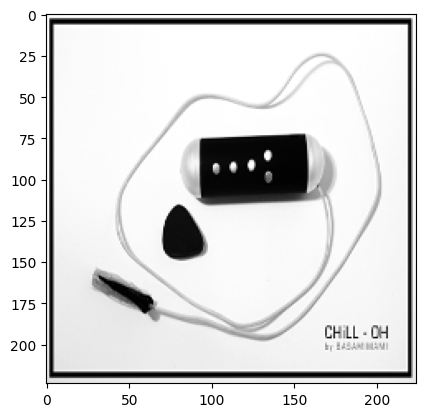

pick


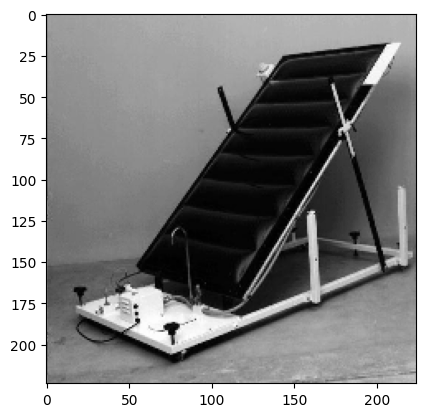

solar_dish


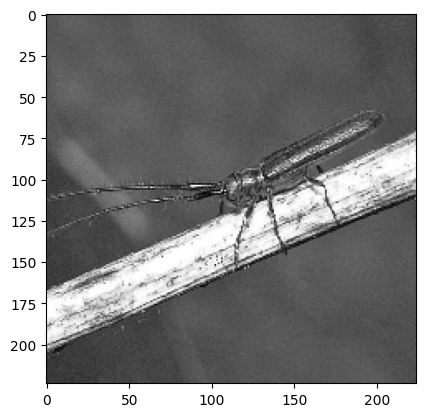

long-horned_beetle


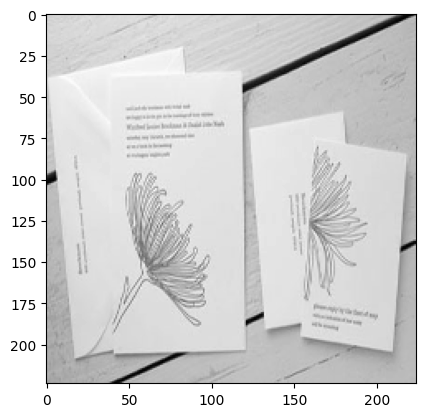

envelope


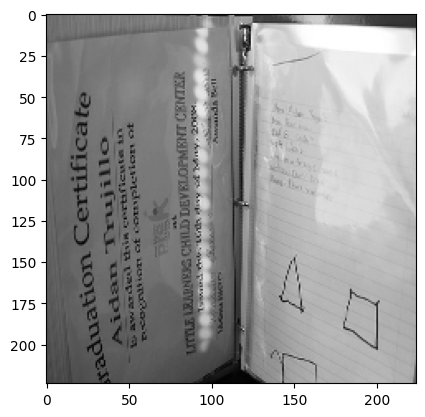

binder


In [8]:
# view train images
view_train_images(train_images, train_labels)

In [9]:
# type of images
for i in range(0, 5):
    print(type(train_images[i]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
# check the shape of images
for i in range(0, 5):
    print(train_images[i].shape)

(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)


## 3) Edge Detection ##

In [11]:
# define edge detection function

def edge_detection(image_arr, low_threshold = 100, high_threshold = 200):
    """ Detect edges in an image """
    # remove single channel dimension
    image_arr = image_arr.squeeze()
    # convert to uint8
    if image_arr.dtype != np.uint8:
        image_arr = (image_arr * 255).astype(np.uint8)
    # detect edges
    edges = cv2.Canny(image_arr, low_threshold, high_threshold)
    return edges

In [12]:
# perform edge detection on images
train_edge_images = [edge_detection(image) for image in train_images]

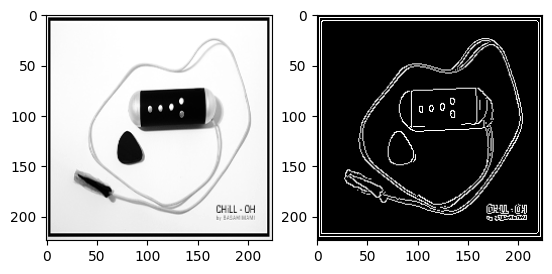

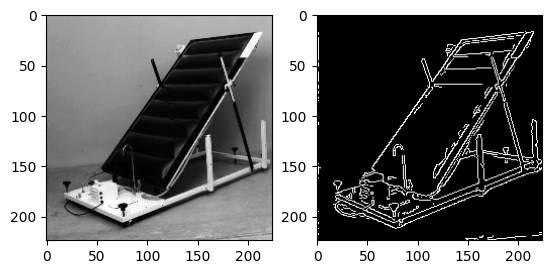

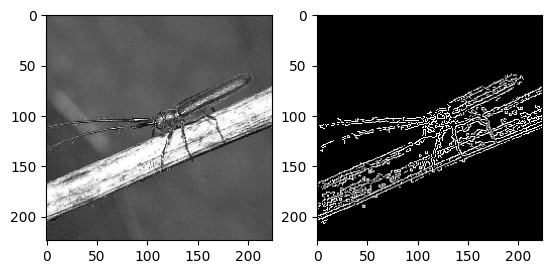

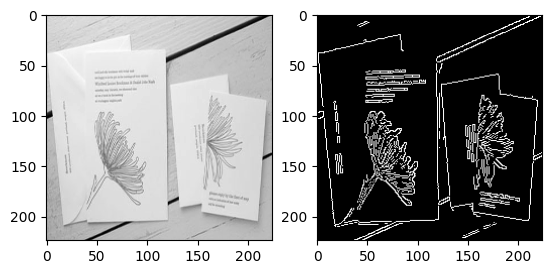

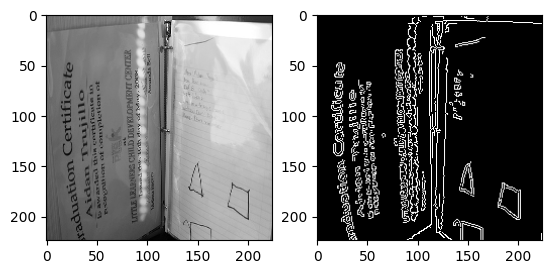

In [13]:
# view edged image
def view_edged_image(image_arrays, image_edge, n):
    """ View an image array """
    for i in range(0, n):
        plt.subplot(1, 2, 1)
        plt.imshow(image_arrays[i], cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(image_edge[i], cmap='gray')
        plt.show()

view_edged_image(train_images, train_edge_images, 5)

## 4) Machine Learning ##

### a) Prepare Data ###


In [14]:
# prepare training data
# tf.compat.v1.disable_eager_execution()
X_train = np.array(train_images)
X_train = np.repeat(X_train, 3, -1)

Y_train = [str(s) for s in train_labels]
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_hot = to_categorical(Y_train, num_classes=1000)

# X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
# Y_hot = tf.convert_to_tensor(Y_hot, dtype=tf.float32)


In [ ]:
# # prepare validation data
# X_val = np.array(val_images)

# Y_val = [str(s) for s in val_labels]
# Y_val = LabelEncoder.fit_transform(Y_val)
# Y_val_hot = to_categorical(Y_val, num_classes=1000)

In [ ]:
# # prepare test data
# X_test = np.array(test_images)

# Y_test = [str(s) for s in X_test]
# Y_test = LabelEncoder.fit_transform(Y_test)
# Y_test_hot = to_categorical(Y_test, num_classes=1000)

### b) Train CNN Model ###

In [15]:
# build and compile the convolutional neural network (CNN) model - ONLY ONCE
# K.clear_session()
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
CNN = keras.Sequential([
                # first convolutional layer
                Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
                BatchNormalization(),
                MaxPooling2D((2, 2)),
                # second convolutional layer with 64 neurons and w/out shape
                Conv2D(64, (3, 3), activation='relu'),
                BatchNormalization(),
                MaxPooling2D((2, 2)),
                # # Flatten out the layers
                # Flatten(),
                # Dense layer with 64 neurons and relu activation
                GlobalAveragePooling2D(),
                BatchNormalization(),
                # Dropout layer to prevent overfitting by dropping 50% of neurons
                Dropout(0.5),
                # Output layer with 1000 classes and softmax activation
                Dense(200, activation='softmax')
        ])

        # compile model with adam, categorical crossentropy, accuracy, precision, and recall
CNN.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', Precision(), Recall()])

# print("Model using device: ", device)

In [19]:
# 1) GPU-build and compile the convolutional neural network (CNN) model - ONLY ONCE
G.collect()
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
# Allow memory growth on the GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)  
# with tf.device('/GPU:0'):
CNN = keras.Sequential([
                # first convolutional layer
                Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
                BatchNormalization(),
                MaxPooling2D((2, 2)),
                # second convolutional layer with 64 neurons and w/out shape
                Conv2D(128, (3, 3), activation='relu'),
                BatchNormalization(),
                MaxPooling2D((2, 2)),
                # third convolutional layer with 64 neurons and w/out shape
                # Conv2D(32, (3, 3), activation='relu'),
                # BatchNormalization(),
                # MaxPooling2D((2, 2)),
                # # Flatten out the layers
                # Flatten(),
                # Dense layer with 64 neurons and relu activation
                GlobalAveragePooling2D(),
                # Dropout layer to prevent overfitting by dropping 50% of neurons
                Dropout(0.5),
                # Output layer with 1000 classes and softmax activation
                Dense(1000, activation='softmax')
        ])

# compile model with adam, categorical crossentropy, accuracy, precision, and recall
CNN.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy', Precision(), Recall()])

# train the model
reduce_lr = RLOP(monitor='val_loss', factor=0.0001, patience=10, min_lr=0)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist_1 = CNN.fit(
    X_train, Y_hot,
    batch_size=16,
    epochs=100,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stop]
)

# plot training results
plot_training_results(hist_1)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
G.collect()

Accuracy is high 69% but val_acc is very low 0.07%

In [ ]:
# 2) GPU-build and compile the convolutional neural network (CNN) model - ONLY ONCE
K.clear_session()
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
# Allow memory growth on the GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
with tf.device('/GPU:0'):
    CNN2 = keras.Sequential([
                    # first convolutional layer
                    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    # second convolutional layer with 64 neurons and w/out shape
                    Conv2D(64, (3, 3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    # third convolutional layer with 64 neurons and w/out shape
                    Conv2D(128, (3, 3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    # # Flatten out the layers
                    # Flatten(),
                    # Dense layer with 64 neurons and relu activation
                    GlobalAveragePooling2D(),
                    BatchNormalization(),
                    # Dropout layer to prevent overfitting by dropping 50% of neurons
                    Dropout(0.4),
                    # Output layer with 1000 classes and softmax activation
                    Dense(1000, activation='softmax')
            ])

    # compile model with adam, categorical crossentropy, accuracy, precision, and recall
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    CNN2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy', Precision(), Recall()])

# train the model
K.clear_session()
hist_2 = CNN2.fit(
    X_train, Y_hot,
    batch_size=8,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop]
)

# plot training results
plot_training_results(hist_2)

Early stopping fails to outperform when compared to the previous model. Accuracy 8.9% for a validation accuracy of 1.8%

In [ ]:
# 3) GPU-build and compile the convolutional neural network (CNN) model - ONLY ONCE
K.clear_session()
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
# Allow memory growth on the GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
with tf.device('/GPU:0'):
    CNN3 = keras.Sequential([
                    # 1st convolutional layer
                    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    # 2nd convolutional layer with 64 neurons and w/out shape
                    Conv2D(64, (3, 3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    # 3rd convolutional layer with 64 neurons and w/out shape
                    Conv2D(128, (3, 3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    # # Flatten out the layers
                    # Flatten(),
                    # Dense layer with 64 neurons and relu activation
                    GlobalAveragePooling2D(),
                    BatchNormalization(),
                    # Dropout layer to prevent overfitting by dropping 10% of neurons
                    Dropout(0.001),
                    # Output layer with 1000 classes and softmax activation
                    Dense(1000, activation='softmax')
            ])

    # compile model with adam, categorical crossentropy, accuracy, precision, and recall
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    CNN3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                    loss='categorical_crossentropy',
                    metrics=['accuracy', Precision(), Recall()])

# train the model
K.clear_session()
hist_3 = CNN3.fit(
    X_train, Y_hot,
    batch_size=8,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop]
)

# plot training results
plot_training_results(hist_3)

Val_acc seems stuck